In [1]:
import numpy as np

# xarray is used to read and plot the downloaded NetCDF files
import xarray as xr
import netCDF4
import sys

import matplotlib.pyplot as plt
import glob, os

import metpy, pint



In [2]:
import numpy as np
from scipy.fft import fft, fft2, ifft, fftfreq
import pandas as pd
import requests
import shutil
import time as time
from os.path import join,expanduser
user_home_dir = expanduser('~')

# xarray is used to read and plot the downloaded NetCDF files
import xarray as xr
import sys

import matplotlib.pyplot as plt


# load the ecco_v4_py package
# here is is assumed to be installed in /home/user/ECCOv4-py
# change as needed for your setup
sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

# from ecco_v4_py import *

In [3]:
dir_path = '/scratch/cimes/ml1994/global_topo_analysis/data/data_topo/'
file_name = 'global_topo_merged_masked_smooth_rough_decomp_ds1_fw50_fds5.nc'


In [4]:
global_topo = xr.open_dataset(dir_path + file_name, engine="netcdf4")


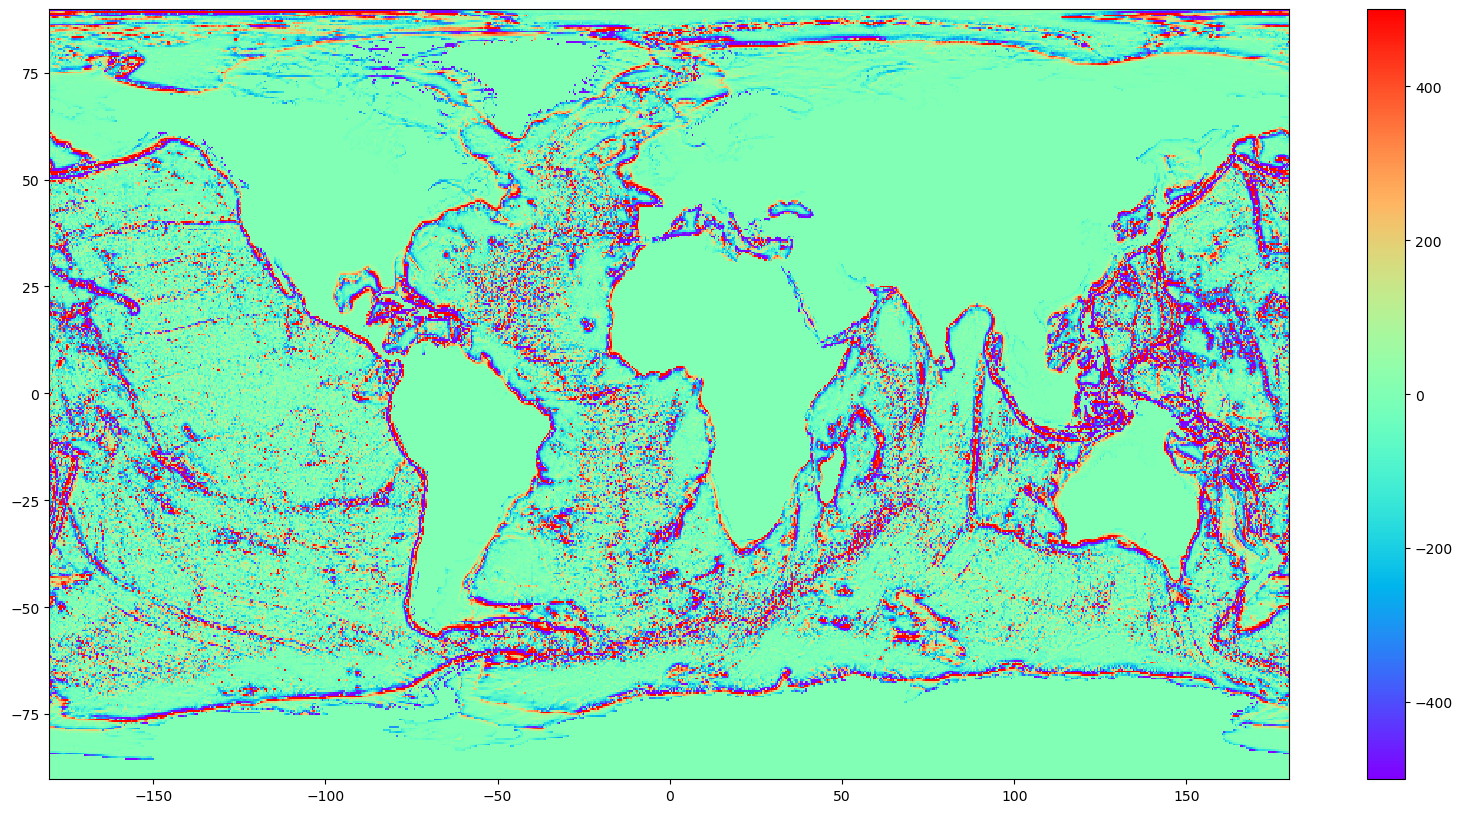

In [5]:

fig, ax = plt.subplots(1,1, figsize=(20,10))

lat = global_topo.smooth_elevation.lat
lon = global_topo.smooth_elevation.lon

# lon, lat = np.meshgrid(lon, lat)


lim = 500

pc1 = ax.pcolormesh(lon[::20], lat[::20], global_topo.rough_elevation.data[::20, ::20] * global_topo.land_mask.data[::20, ::20], vmin=-lim, vmax=lim, cmap=plt.get_cmap('rainbow'))

# pc1 = ax.pcolormesh(lon[300:1260], lat[300:1260], global_topo.rough_elevation.data[300:1260, 300:1260] + global_topo.smooth_elevation.data[300:1260, 300:1260], cmap=plt.get_cmap('rainbow'))

# pc1 = ax.pcolormesh(lon[300:1260], lat[300:1260], global_topo.smooth_elevation.data[300:1260, 300:1260], cmap=plt.get_cmap('rainbow'))

# pc1 = ax.pcolormesh(lon, lat, global_topo.rough_elevation.data * global_topo.land_mask.data, vmin=-lim, vmax=lim, cmap=plt.get_cmap('rainbow'))


# ax.set_xlim(-175,-125)
# ax.set_ylim(-75,-50)

plt.colorbar(pc1)

# defining ``roughness''

Plan for now is to define a stencil, say 2degX2deg.

In that box I define (i) roughness via Fourier methods, and

(ii) slope as average slope magnitude in box



In [6]:
def h_rms(topo_box):

    N = topo_box.shape[0]
    
    # xf = fftfreq(N, dx)[:N//2]
    # yf = np.copy(xf)
    
    h_hat = fft2(topo_box)

    h_abs = (2.0 * N**-2) * np.abs(h_hat[0:N//2, 0:N//2])
    
    return h_abs

In [7]:
d_deg = np.mean(np.diff(lat.data))

box_side_deg = 2.0
N_box_side = (box_side_deg // d_deg).astype(int)

i = np.round(0.5*len(lon)).astype(int)
j = np.round(0.2*len(lat)).astype(int)

topo_box = global_topo.rough_elevation[j:j+N_box_side-1, i:i+N_box_side-1]

# h_abs = h_rms(topo_box)

NameError: name 'h_abs' is not defined

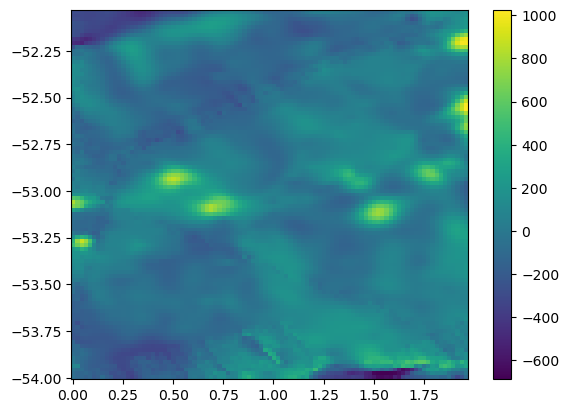

<Figure size 640x480 with 0 Axes>

In [8]:


pc0 = plt.pcolormesh(lon[i:i+N_box_side-1], lat[j:j+N_box_side-1], topo_box)
plt.colorbar(pc0)

plt.figure()
pc1 = plt.pcolormesh(h_abs)

plt.colorbar(pc1)

np.sqrt(np.mean(topo_box**2))


detab_dx, detab_dy = metpy.calc.geospatial_gradient(topo_box)

plt.figure()
plt.pcolormesh(detab_dx)

In [43]:
# N = 1000

# dx = n_cyc/N

# n_cyc = 10
# f = 1
# omega = f * 2 * np.pi

# x = np.linspace(0,n_cyc,N)
# y = 2 * np.cos(x * omega)

# plt.plot(x,y)

# xf = fftfreq(N, dx)[:N//2]
# yhat = fft(y)

# plt.figure()
# plt.plot(xf, (2.0 / N) * np.abs(yhat[0:N//2]))
# plt.xlim(0,5)

In [7]:
# N = 1000

# dx = n_cyc/N

# n_cyc = 10
# f = 1
# omega = f * 2 * np.pi

# x = np.linspace(0,n_cyc,N)
# y = np.copy(x)

# x, y = np.meshgrid(x, y)

# z = 2 * np.cos(x * omega) * np.cos(y * omega)
# # z = 2 * np.cos(x * omega + y * omega)


# pc1 = plt.pcolormesh(x, y, z)
# plt.colorbar(pc1)

# xf = fftfreq(N, dx)[:N//2]
# yf = np.copy(xf)
# zhat = fft2(z)

# plt.figure()
# pc1 = plt.pcolormesh(xf, yf, (2.0 * N**-2) * np.abs(zhat[0:N//2, 0:N//2]))
# plt.colorbar(pc1)

In [57]:
def make_avg_slope_map(topo_in, N_box_side, N_decimate):
    Nx_out = np.ceil(np.shape(topo_in)[1]/N_decimate).astype(int)-1
    Ny_out = np.ceil(np.shape(topo_in)[0]/N_decimate).astype(int)-1

    lon_out = np.zeros(Nx_out)
    lat_out = np.zeros(Ny_out)
    
    arr_out = np.zeros((Ny_out, Nx_out))
    
    half_width = np.ceil(N_box_side/2).astype(int)

    i0=-1
    for i in np.arange(0, np.shape(topo_in)[0]-N_decimate, step=N_decimate):
        print(str(i0))
        i0+=1
        j0=-1

        lat_out[i0] = topo_in.lat.data[i+half_width]
        
        for j in np.arange(0, np.shape(topo_in)[1]-N_decimate, step=N_decimate):
            j0+=1

            detab_dx, detab_dy = metpy.calc.geospatial_gradient(topo_in[i:i+N_decimate, j:j+N_decimate])

            arr_out[i0, j0] = np.nanmean(np.sqrt(detab_dx**2 + detab_dy**2)).magnitude

            lon_out[j0] = topo_in.lon.data[j+half_width]

    slope_ds = xr.Dataset(
    data_vars=dict(
        h_slope=(["lat", "lon"], arr_out),
    ),
    coords=dict(
        lon=("lon", lon_out),
        lat=("lat", lat_out),
    ),
    attrs=dict(description="topography data"))

    return slope_ds

def make_roughness_map(topo_in, N_box_side, N_decimate):
    Nx_out = np.ceil(np.shape(topo_in)[1]/N_decimate).astype(int)-1
    Ny_out = np.ceil(np.shape(topo_in)[0]/N_decimate).astype(int)-1

    lon_out = np.zeros(Nx_out)
    lat_out = np.zeros(Ny_out)
    
    arr_out = np.zeros((Ny_out, Nx_out))
    half_width = np.ceil(N_box_side/2).astype(int)
    # arr_ext = np.hstack((np.flip(arr_ext[:,0:half_width],axis=1),arr_ext,np.flip(arr_ext[:,-half_width:],axis=1)))

    i0=-1
    for i in np.arange(0, np.shape(topo_in)[0]-half_width, step=N_decimate):
        i0+=1
        j0=-1

        lat_out[i0] = topo_in.lat.data[i+half_width]
        for j in np.arange(0, np.shape(topo_in)[1]-half_width, step=N_decimate):
            j0+=1

            arr_out[i0, j0] = np.sqrt(np.nanmean(topo_in[i:i+half_width, j:j+half_width]**2))

            lon_out[j0] = topo_in.lon.data[j+half_width]

    rough_ds = xr.Dataset(
    data_vars=dict(
        h_rms=(["lat", "lon"], arr_out),
    ),
    coords=dict(
        lon=("lon", lon_out),
        lat=("lat", lat_out),
    ),
    attrs=dict(description="topography data"))

    return rough_ds # lon_out, lat_out, arr_out # 


# def make_roughness_map(topo_in, N_box_side, N_decimate):
#     Nx_out = np.ceil(np.shape(topo_in)[0]/N_decimate).astype(int)
#     Ny_out = np.ceil(np.shape(topo_in)[1]/N_decimate).astype(int)
    
#     arr_out = np.zeros((Nx_out, Ny_out))
#     half_width = np.ceil(N_box_side/2).astype(int)

#     topo_ext = np.vstack((topo_in[-half_width:,:],topo_in,topo_in[0:half_width,:]))
#     topo_ext = np.hstack((topo_ext[:,-half_width:],topo_ext,topo_ext[:,0:half_width]))
#     # arr_ext = np.hstack((np.flip(arr_ext[:,0:half_width],axis=1),arr_ext,np.flip(arr_ext[:,-half_width:],axis=1)))

#     i0=-1
#     for i in np.arange(0, np.shape(topo_in)[0], step=N_decimate):
#         i0+=1
#         j0=-1
#         for j in np.arange(0, np.shape(topo_in)[1], step=N_decimate):
#             j0+=1

#             arr_out[i0, j0] = np.sqrt(np.nanmean(topo_ext[i:i+N_decimate, j:j+N_decimate]**2))

#     return arr_out

In [64]:
d_deg = np.mean(np.diff(lat.data))

box_side_deg = 2.0
N_box_side = (box_side_deg // d_deg).astype(int)
N_decimate = np.round(N_box_side/2).astype(int)

topo_in = global_topo.rough_elevation
topo_in.data[~global_topo.land_mask.data] = np.nan

global_roughness = make_roughness_map(topo_in, N_box_side, N_decimate)


/tmp/ipykernel_325063/1633777669.py:61: RuntimeWarning: Mean of empty slice
  arr_out[i0, j0] = np.sqrt(np.nanmean(topo_in[i:i+half_width, j:j+half_width]**2))


In [58]:
topo_in = global_topo.smooth_elevation
topo_in.data[~global_topo.land_mask.data] = np.nan

global_slope = make_avg_slope_map(topo_in, N_box_side, N_decimate)

-1


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

0


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

1


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

2


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

3


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

4


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

5


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

6


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

7


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

8


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

9


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

10


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

11


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

12


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

13


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

14


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

15


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

16


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

17


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

18


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

19


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

20


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

21


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

22


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)


38


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)


39


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)


40


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)


41


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

42


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)


43


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

44


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

45


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

46


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)


47


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

48


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

49


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

50


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

51


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

52


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

53


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

54


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

55


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

56


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

57


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

58


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

59


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

60


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

61


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

62


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

63


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

64


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

65


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

66


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

67


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

68


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

69


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

70


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

71


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

72


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

73


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

74


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

75


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

76


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

77


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

78


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

79


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

80


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

81


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

82


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

83


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

84


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

85


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

86


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

87


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

88


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

89


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

90


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

91


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

92


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

93


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

94


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

95


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

96


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

97


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

98


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

99


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

100


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

101


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

102


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

103


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

104


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

105


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

106


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

107


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

108


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

109


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

110


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

111


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

112


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

113


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

114


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

115


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

116


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

117


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

118


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

119


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

120


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

121


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

122


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

123


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

124


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

125


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

126


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

127


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

128


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

129


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

130


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

131


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

132


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

133


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

134


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

135


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

136


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

137


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

138


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

139


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

140


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

141


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

142


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

143


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

144


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

145


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

146


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

147


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

148


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

149


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

150


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

151


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

152


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

153


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

154


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

155


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

156


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

157


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

158


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

159


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

160


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

161


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

162


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

163


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

164


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

165


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

166


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

167


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

168


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

169


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

170


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

171


/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO_ECCO_env/lib/python3.13/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/home/ml1994/.conda/envs/GEBCO

172
173
174
175
176
177


In [31]:
np.shape(topo_in)

(8640, 17280)

In [69]:
global_roughness.h_rms

<xarray.DataArray 'h_rms' (lat: 179, lon: 359)> Size: 514kB
array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       ...,
       [269.08538818, 282.93945312, 281.69641113, ..., 259.09515381,
        236.02375793, 263.82995605],
       [156.50294495, 208.96522522, 162.2335968 , ...,  95.96893311,
        151.95353699, 177.63485718],
       [885.75244141, 891.24053955, 867.96826172, ..., 667.30224609,
        753.93237305, 750.11755371]], shape=(179, 359))
Coordinates:
  * lon      (lon) float64 3kB -179.0 -178.0 -177.0 -176.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 1kB -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0

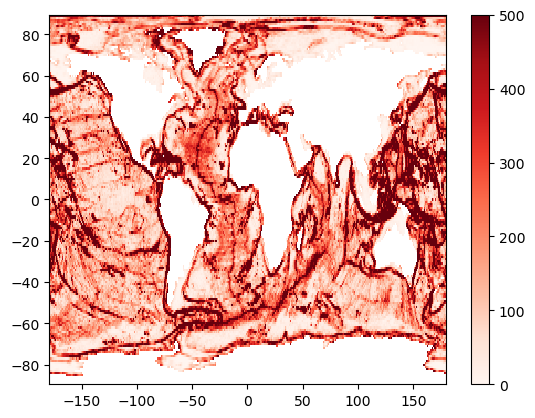

In [70]:
lim = 500

pc1 = plt.pcolormesh(global_roughness.lon.data, global_roughness.lat.data, global_roughness.h_rms, vmin=0, vmax=lim, cmap=plt.cm.Reds)

plt.colorbar(pc1)

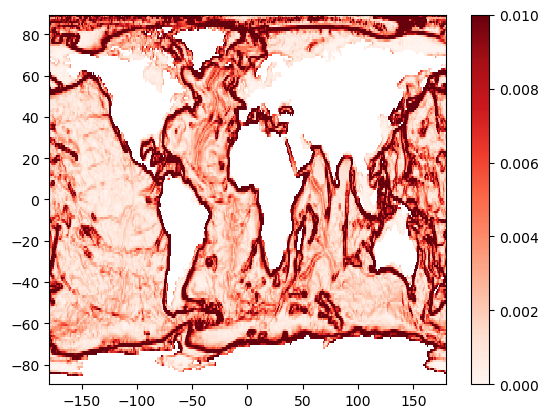

In [71]:
lim = 1e-2

pc1 = plt.pcolormesh(global_slope.lon.data, global_slope.lat.data, global_slope.h_slope, vmin=0, vmax=lim, cmap=plt.cm.Reds)

plt.colorbar(pc1)

In [79]:
dir_path = '/scratch/cimes/ml1994/global_topo_analysis/data/data_topo/'
file_name_rough = 'global_rough.nc'
file_name_slope = 'global_slope.nc'

# global_roughness.to_netcdf(path=dir_path + file_name_rough)
# global_slope.to_netcdf(path=dir_path + file_name_slope)

global_roughness = xr.open_dataset(dir_path + file_name_rough, engine="netcdf4")
global_slope     = xr.open_dataset(dir_path + file_name_slope, engine="netcdf4")



In [94]:
r_max = 500
s_max = 1e-2

global_roughness_limited = np.copy(global_roughness.h_rms.data)
global_roughness_limited[global_roughness.h_rms>r_max] = r_max
global_roughness_limited = global_roughness_limited / r_max

global_slope_limited = np.copy(global_slope.h_slope.data)
global_slope_limited[global_slope.h_slope>s_max] = s_max
global_slope_limited = global_slope_limited / s_max


red_values = 256 * global_roughness_limited / r_max
blue_values = 256 * global_slope_limited / s_max


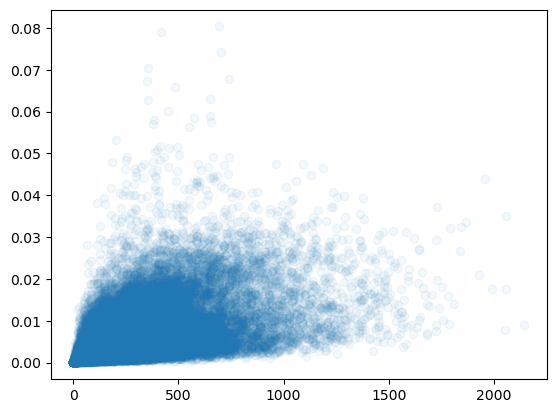

In [81]:
plt.scatter(global_roughness.h_rms, global_slope.h_slope, alpha=0.05)

In [88]:
# from pycolormap_2d import ColorMap2DCubeDiagonal

# # Create the color map object.
# cmap = ColorMap2DCubeDiagonal()

# # Get the color value.
# color = cmap(0.2, 0.6)

In [89]:
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes

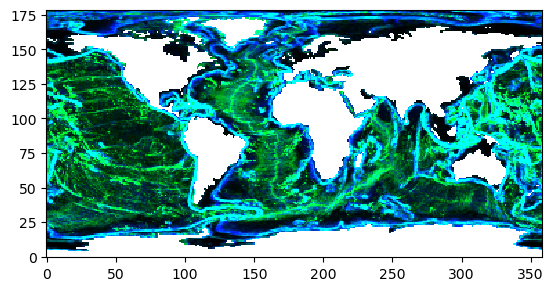

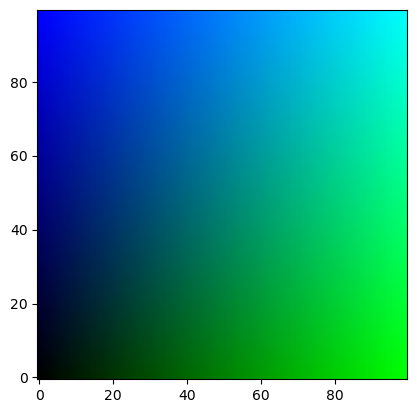

In [134]:
# rgb = np.random.random((5, 5, 3))

# fig = plt.figure()
# ax = RGBAxes(fig, [0.1, 0.1, 0.8, 0.8])
# ax.imshow_rgb(rgb[:,:,0],rgb[:,:,1],rgb[:,:,2],interpolation='none')

plt.figure()
plt.imshow(rgb_topo, origin='lower', interpolation='none')

plt.figure()
plt.imshow(rgb_key, origin='lower', interpolation='none')

In [132]:
rgb_topo = np.stack([np.zeros_like(global_slope_limited), global_roughness_limited, global_slope_limited], axis=2)

scale_2dx, scale_2dy = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
rgb_key = np.stack([np.zeros_like(scale_2dx), scale_2dx, scale_2dy], axis=2)